# Lyricizer: a model that guesses the artist by song lyrics!

### Import modules

In [1]:
import requests
import re
import time
import spacy
import dataclasses
import dill
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import (
    RandomUnderSampler,
    NearMiss,
)  # python 3.9+ install with: conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
)  # python 3.9+ install with: conda install -c conda-forge imbalanced-learn
from pathlib import Path
from bs4 import BeautifulSoup
from langdetect import detect_langs
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
)

### Create classes and methods
##### Create Lyricizer class 
Downloads the lyrics for each song of a given artist and cleans it

In [2]:
@dataclasses.dataclass
class Lyricizer:
    artist: str
    path_save: str
    method_stringclean: str = None
    base_url: str = "https://www.lyrics.com"

    @staticmethod
    def get_website_content(
        url: str,
        path_save: str = None,
        verbose: bool = False,
        t_wait: float = np.random.uniform(1, 3),
        *args,
        **kwargs,
    ) -> str:
        """
        Requests the html content of a website.

        Parameters
        ----------
        url : str
            URL to the website.
        path_save : str, optional
            Path to save the content of the website. If None provided,
            content is not saved, by default None.
        verbose : bool, optional
            Whether or not status code should always be printed or just
            for errors, by default False.
        t_wait : float, optional
            Time, in seconds, to wait before sending the request, by default.
            Random float between 1 and 3. Meant to reduce the likelihood
            of getting banned or timed out by requested server.
        *args / *kwargs
            Will be passed to the pathlib.write_text() function.

        Returns
        -------
        request.text : str
            Website content.
        """
        if t_wait:
            time.sleep(t_wait)
        try:
            req = requests.get(url)
            if verbose:
                print(f"Website status code: {req.status_code}")
            if (req.status_code >= 400) and (req.status_code < 500):
                print(
                    f"\nERROR: User authorization or input error. Server response: {req.status_code}"
                )
            elif (req.status_code >= 500) and (req.status_code < 600):
                print(
                    f"\nERROR: Server-sided error. Server response: {req.status_code}"
                )
            if path_save:
                try:
                    path_save = Path(
                        str(Path(".").resolve()) + "/" + path_save
                    )  # this is nasty, but VSC seems to mess up pathlib functions
                    path_save.parent.mkdir(exist_ok=True, parents=True)
                    path_save.write_text(req.text, *args, **kwargs)
                except Exception as e:
                    print(e, "\nERROR: Website could not be written to file.")

            return req.text
        except Exception as e:
            print(e, "\nERROR: Could not request url !")

    @staticmethod
    def get_lang_proba(text: str, language: str = "en") -> float:
        """
        Detects the likelihood a given string is in the specified language.

        Parameters
        ----------
        text : str
            The text string that should be analyzed.
        language : str, optional
            The language code for the analyzer, by default "en" for English.

        Returns
        -------
        float
            Returns the probability that the text is in the language specified.
        """
        detections = detect_langs(text)
        for detection in detections:
            if detection.lang == language:

                return detection.prob

        return 0.0

    def get_lyrics_content(
        self,
        save_df: bool = True,
        pattern: str = r'href=[\'"]?([^\'" >]+)',
        *args,
        **kwargs,
    ) -> pd.DataFrame:
        """
        Extracts url to the lyrics for each song of a given artist.

        Parameters
        ----------
        save_df : bool, optional
            Whether or not to save the created df should be saved to a .csv.
        pattern : raw string, optional
            Regular expression search pattern to extract urls to the lyrics of each song.
        *args / *kwargs
            Will be passed to the get_website_content() function.

        Returns
        -------
        df_songs : pd.DataFrame
            DataFrame containing artist, song id of lyrics.com, url to lyrics.
        """
        path_save = self.path_save + "df_lyrics.csv"
        if Path(path_save).is_file():
            try:
                self.df_songs = Path(path_save).read_text()
                print(f"Found base page content for all lyrics of {self.artist}!")

                return self.df_songs
            except Exception as e:
                print(e, f"\nError: Base page content file is not readable...")
        else:
            print(
                f"No base page content for all lyrics of {self.artist} found. Creating it..."
            )
            # Get overview
            website_content = self.get_website_content(
                url=f"{self.base_url}/artist/{self.artist}",
                *args,
                **kwargs,
            )
            # Find only urls of songs and extend song links with new song id and link
            find_urls = re.findall(pattern, website_content)
            artist_formats = [x.casefold() for x in ["lyric"] + self.artist.split(" ")]
            self.df_songs = pd.DataFrame(columns=["id", "url"])
            for _, url in enumerate(find_urls):
                if all(
                    x in url.casefold() for x in artist_formats
                ):  # ensure catch whitespace bands (e.g. "Green Day"): urls fills in "+", "-" or "20%" instead) - also, prevent case-sensitivity
                    id = url.split("/")[2]
                    url = self.base_url + url
                    self.df_songs = pd.concat(
                        [
                            self.df_songs,
                            pd.DataFrame.from_dict(
                                {
                                    "artist": self.artist,
                                    "id": id,
                                    "url": [url],
                                }
                            ),
                        ],
                        ignore_index=True,
                    )
            if save_df:
                Path(self.path_save).mkdir(exist_ok=True, parents=True)
                self.df_songs.to_csv(path_save)

            return self.df_songs

    def get_individual_lyrics(
        self, save_df: bool = True, *args, **kwargs
    ) -> pd.DataFrame:
        """
        Extracts and locally stores the lyrics for each song of a given artist.

        Parameters
        ----------
        save_df : bool, optional
            Whether or not to save the created df should be saved to a .csv.
        *args / *kwargs
            Will be passed to the get_website_content() function.

        Returns
        -------
        df_songs : pd.DataFrame
            DataFrame containing artist, song id of lyrics.com, url to lyrics
            and path to local file.
        """
        if Path(self.path_save + "df_lyrics.csv").is_file():
            self.df_songs = pd.read_csv(self.path_save + "df_lyrics.csv", index_col=0)
            # Check whether files are missing or an update is necessary
            update_req = True
            if "lyrics_path" in self.df_songs.columns:
                update_req = False
                for path_song in self.df_songs["lyrics_path"]:
                    if not Path(path_song[1:]).is_file():
                        update_req = True
                        print(
                            "Existing list not up-to-date or files are missing. Updating..."
                        )
                        break
                print(f"Lyrics for {self.artist} already downloaded!")
            if update_req:
                print(
                    f"Did not find lyrics for {self.artist}. Downloading lyrics all songs..."
                )
                lyrics_path = []
                for id in self.df_songs["id"]:
                    id_path = f"/{self.path_save}/{id}_song.txt"
                    if Path(
                        id_path[1:]
                    ).is_file():  # if interrupted or when updating, we skip already downloaded lyrics
                        lyrics_path.append(id_path)
                        continue
                    else:
                        self.get_website_content(
                            url=self.df_songs.loc[self.df_songs["id"] == id][
                                "url"
                            ].item(),
                            path_save=id_path,
                            *args,
                            **kwargs,
                        )
                        lyrics_path.append(id_path)
                self.df_songs["lyrics_path"] = lyrics_path
                if save_df:
                    Path(self.path_save).mkdir(exist_ok=True, parents=True)
                    self.df_songs.to_csv(self.path_save + "df_lyrics.csv")

            return self.df_songs
        else:
            print("Song df doesn't exist! Make sure to get urls first.")

    def prep_data(
        self,
        clean_check: bool = True,
        *args,
        **kwargs,
    ) -> pd.DataFrame:
        """
        Formats (i.e., cleans) the lyrics for each song of a given artist in human readable text.

        Parameters
        ----------
        clean_check : bool, optional
            Whether or not it should be checked whether the lyrics of each
            song have already been cleaned.
        *args / *kwargs
            Will be passed to the pathlib.read_text function.

        Returns
        -------
        df_songs : pd.DataFrame
            DataFrame containing artist, song id of lyrics.com, url to lyrics,
            path to local file, actual lyrics formatted in human readable text.
        """
        path_save = self.path_save + "df_lyrics.csv"
        if Path(path_save).is_file():
            self.df_songs = pd.read_csv(path_save, index_col=0)
            if (
                "lyrics (clean)" in self.df_songs.columns and clean_check
            ):  # a non-thorough test whether lyrics have been prepared
                print("Data already prepared. Moving on...")

                return self.df_songs
            else:
                print(
                    f"Preparing data of {self.artist}... (clean_check = {clean_check})"
                )
                if self.method_stringclean == "spacy":
                    model = spacy.load("en_core_web_md")

                lyrics_all = []
                for _, lyrics_path in enumerate(self.df_songs["lyrics_path"]):
                    raw_song_lyrics = Path(
                        str(Path(".").resolve()) + str(Path(lyrics_path))
                    ).read_text(*args, **kwargs)
                    song_lyrics = BeautifulSoup(raw_song_lyrics, "html.parser")
                    try:
                        song_lyrics = song_lyrics.body.find(
                            class_="lyric-body"
                        ).text.lower()  # file gets stripped of everything but the \n linebreaks and \r carriage returns
                        song_lyrics = (
                            song_lyrics.encode("ascii", "replace")
                            .decode()
                            .replace("?", " ")
                        )  # remove remaining unicode, e.g. \u
                        song_lyrics = (
                            song_lyrics.replace("\n", " ")
                            .replace("\r", "")
                            .replace('b"', "")
                        )  # remove line breaks, carriage returns and byte-type leftovers from encoding (b")
                        song_lyrics = re.sub(
                            r"\[(.*?)\]", "", song_lyrics
                        )  # remove text in square brackets (e.g., [Chorus])
                        if self.method_stringclean == "spacy":
                            clean_string = []
                            for token in model(song_lyrics):
                                if (
                                    not token.is_stop
                                    and not token.is_punct
                                    and not token.like_num
                                ):
                                    clean_string.append(token.lemma_)
                            song_lyrics = " ".join(clean_string)
                        song_lyrics = " ".join(
                            song_lyrics.split()
                        )  # if spacy isn't run, remove all whitespaces
                    except:
                        song_lyrics = np.nan
                    lyrics_all.append(song_lyrics)
                self.df_songs["lyrics (clean)"] = lyrics_all
                self.df_songs.to_csv(path_save)
                print(f"Lyrics of {self.artist} cleaned and saved.")

                return self.df_songs
        else:
            print(f"ERROR: Song dataframe of {self.artist} could not be loaded !")

##### Create LyricizerModelling class 
Models and evaluates model performance

In [3]:
@dataclasses.dataclass
class LyricizerModelling:
    X_train: pd.DataFrame = None
    y_train: pd.DataFrame = None
    X_test: pd.DataFrame = None
    y_test: pd.DataFrame = None
    unmodelled_data: pd.DataFrame = None

    @staticmethod
    def data_undersampler(
        max_sample_size: int,
        df: pd.DataFrame,
        y_label: str = None,
        method: str = "pandas",
        method_imblearn: str = "rus",
        *args,
        **kwargs,
    ):
        """
        Undersamples features of a given dataset (a pandas Dataframe) to a given maximum of observations
        either using pd.sample or Undersample from the imblearn module.

        Parameters
        ----------
        max_sample_size : int
            Maximum sample size for each target class. In case a given class is < max_sample_size, the data
            for that class is unchanged.
        df : pd.DataFrame
            Data (df) to undersample.
        y_label : str, optional
            Label of the target used as column name in data, defaults to None but needs to be define for
            when method == "pandas".
        method : str, optional
            Method for undersampling. "pandas" uses the pd.DataFrame.sample method. "imblearn" uses imblearn
            module to achieve undersampling, by default "pandas".
        method_imblearn : str, optional
            Method for imblearn undersampling. "rus" corresponds to Random undersampling which selects a
            subsample from the majority class randomly. "nm" refers to Near Miss, which selects the
            subsample based on the distances between the majority class datapoints and the minority
            class datapoints. In NearMiss3 the nearest n neighbors to each minority sample is selected,
            and then the furthest point among these is eliminated. In versions 1 and 2, the average
            and minimum distances between points are used as selection criteria rather than the largest.
        *args / *kwargs
            Will be passed to the pd.DataFrame.sample(), RandomUnderSampler() or NearMiss() function
            depending on the chosen method parameters.

        Returns
        -------
        if method == "pandas":
        tuple[pd.DataFrame, pd.DataFrame]
            Returns to pd.DataFrames. df_undersamp is the undersampled dataframe ready for modelling.
            df_undersamp_reject contains all rejected feature values.
        if method == "imblearn":
            Returns imblearn, either a random undersampling or near miss, object which needs to be used
            by calling its fit_resample method to obtain a resampled X_train, y_train dataset
        """
        print(f"Restricting max n for each feature to {max_sample_size}...")
        if method == "pandas":
            df_select, df_reject = (
                [],
                [],
            )  # df with max_sample_size n for each feature class and df with all rejected n for each feature class (we can use the latter for testing our model independently)
            for x_class in df[y_label].unique():
                if df.loc[df[y_label] == x_class].shape[0] > max_sample_size:
                    select = df.loc[df[y_label] == x_class].sample(
                        n=max_sample_size, *args, **kwargs
                    )
                    df_select.append(select)
                    reject = (
                        pd.merge(
                            df.loc[df[y_label] == x_class],
                            select,
                            indicator=True,
                            how="outer",
                        )
                        .query('_merge=="left_only"')
                        .drop("_merge", axis=1)
                    )
                    df_reject.append(reject)
                else:
                    df_select.append(df.loc[df[y_label] == x_class])
            # Rebuilt dfs for modelling (selected) and testing (rejected) - TBC: we could also rebuilt the original lyrics_data from these
            df_undersamp = pd.concat(df_select).dropna().reset_index(drop=True)
            df_undersamp_reject = pd.concat(df_reject).dropna().reset_index(drop=True)

            return df_undersamp, df_undersamp_reject

        elif method == "imblearn":
            if method_imblearn == "rus":
                imblearn_obj = RandomUnderSampler(
                    sampling_strategy={0: max_sample_size}, *args, **kwargs
                )
            elif method_imblearn == "nm":
                imblearn_obj = NearMiss(
                    sampling_strategy={0: max_sample_size}, *args, **kwargs
                )

            return imblearn_obj

    @staticmethod
    def data_oversampler(
        min_sample_size: int,
        df: pd.DataFrame,
        y_label: str,
        method: str = "pandas",
        method_imblearn: str = "ros",
        *args,
        **kwargs,
    ):
        """
        Undersamples features of a given dataset (a pandas Dataframe) to a given maximum of observations
        either using pd.sample or Undersample from the imblearn module.

        Parameters
        ----------
        min_sample_size : int
            Minimum sample size for each target class. In case a given class is > min_sample_size, the data
            for that class is unchanged.
        df : pd.DataFrame
            Data (df) to oversample.
        y_label : str, optional
            Label of the target used as column name in data, defaults to None but needs to be define for
            when method == "pandas".
        method : str, optional
            Method for oversampling. "pandas" uses the pd.DataFrame.sample method. "imblearn" uses imblearn
            module to achieve oversampling, by default "pandas".
        method_imblearn : str, optional
            Method for imblearn oversampling. "ros" corresponds to Random undersampling which selects a
            subsample from the majority class randomly. "smote" refers to SMOTE.
        *args / *kwargs
            Will be passed to the pd.DataFrame.sample(), RandomOverSampler() or SMOTE() function
            depending on the chosen method parameters.

        Returns
        -------
        if method == "pandas":
        tuple[pd.DataFrame, pd.DataFrame]
            Returns to pd.DataFrames. df_undersamp is the undersampled dataframe ready for modelling.
            df_undersamp_reject contains all rejected feature values.
        if method == "imblearn":
            Returns imblearn, either a random oversampling or SMOTE, object which needs to be used
            by calling its fit_resample method to obtain a resampled X_train, y_train dataset
        """
        if method == "pandas":
            print("Not implemented yet.")

        elif method == "imblearn":
            if method_imblearn == "ros":
                imblearn_obj = RandomOverSampler(
                    sampling_strategy={1: min_sample_size}, *args, **kwargs
                )
            elif method_imblearn == "smote":
                imblearn_obj = SMOTE(
                    sampling_strategy={1: min_sample_size}, *args, **kwargs
                )
            return imblearn_obj

    def model_train(
        self, estimator_object, param_grid: dict = None, *args, **kwargs
    ) -> tuple[Pipeline, float]:
        """
        Builds a pipeline with column vectorizer and tfidf transformer that fits a given estimator.
        Also does gridsearch, if a parameter grid is provided.

        Parameters
        ----------
        estimator_object : Scikit-learn estimator object
            Scikit-learn estimator object that should be fitted.
        param_grid : dict, optional
            Parameter grid for GridSearchCV. If not provided, no grid search is performed, default None.
        *args / *kwargs
            Will be passed to the sklearn.GridsearchCV() function.

        Returns
        -------
        Pipeline : Scitkit-learn Pipeline object
            Pipeline object with fitted estimator as class attribute.
        accuracy : float
            Classification accuracy obtained with sklearn score method.
        """
        print(f"Building and fitting {estimator_object.__class__.__name__}...")
        self.pipe = Pipeline(
            [
                (
                    "vector",
                    CountVectorizer(lowercase=True, ngram_range=(1, 2)),
                ),  # ngrams massively increases runtime
                ("tfidf", TfidfTransformer()),
                ("classifier", estimator_object),
            ]
        )  # Note: Combine vector and tfidf steps by using TfidfVectorizer()
        if param_grid:
            self.pipe = GridSearchCV(
                estimator=self.pipe,
                param_grid=param_grid,
                *args,
                **kwargs,
            )
        self.pipe.fit(self.X_train, self.y_train)
        train_accuracy = self.pipe.score(self.X_train, self.y_train)

        return self.pipe, train_accuracy

    def model_evaluate(
        self,
        model: Pipeline = None,
        average: str = "micro",
        plot_confusion: bool = False,
        normalize_conmat: bool = True,
        *args,
        **kwargs,
    ) -> tuple[float, float, float, float]:
        """
        Evaluates a given model (the fitted Pipeline object) and returns basic metrics (accuracy,
        precision, recall, and f1-score). If requested plots multiclass confusion matrices.

        Parameters
        ----------
        model : Scitkit-learn Pipeline object, optional
            Pipeline object with fitted estimator. If not provided, it will be attempted to use the class
            instance-specific object which only exists if the instance has run model_train before,
            by default None.
        average : str, optional
            Averaging method for calculating sklearn's precision, recall and f1 score, by default "micro".
        plot_confusion : bool, optional
            Whether or not a confusion matrix should be plotted, by default False. Works for
            multiclass problems, too.
        normalize_conmat : bool, optional
            Whether or not the values of the confusion matrix are normalized, by default True.
            Is ignored, if plot_confusion is False.
        *args / *kwargs
            Will be passed to the seaborn.heatmap() function.

        Returns
        -------
        accuracy : float
            Accuracy score on test data predictions.
        precision : float
            Precision score on test data predictions.
        recall : float
            Recall score on test data predictions.
        f1score : float
            F1-score on test data predictions.
        """
        if not model:
            try:
                print("No model provided, attempting to use instance-specific model...")
                model = self.pipe
            except Exception as e:
                raise Exception(
                    e,
                    "No model found. Did you forgot to provide a model or did you not run model_train ?",
                )
        try:
            model_name = model.estimator["classifier"].__class__.__name__
        except:  # if no gridsearch
            model_name = model["classifier"].__class__.__name__
        y_pred = model.predict(self.X_test)
        print(
            "\n",
            model_name,
            "Model\n",
            "Predicted labels\n",
            pd.Series(y_pred).value_counts(),
            "\n\nActual labels\n",
            pd.Series(self.y_test).value_counts(),
        )
        accuracy = accuracy_score(
            self.y_test,
            y_pred,
        )
        precision = precision_score(self.y_test, y_pred, average=average)
        recall = recall_score(self.y_test, y_pred, average=average)
        f1score = f1_score(self.y_test, y_pred, average=average)
        if plot_confusion:
            palette = sns.color_palette("YlOrBr", as_cmap=True)
            con_mat = confusion_matrix(self.y_test, y_pred)
            if normalize_conmat:
                con_mat = con_mat.astype("float") / con_mat.sum(axis=1)[:, np.newaxis]
            _, ax = plt.subplots()
            sns.heatmap(
                con_mat,
                ax=ax,
                annot=True,
                fmt=".2f",
                linewidths=1,
                linecolor="white",
                cmap=palette,
                cbar=False,
                *args,
                **kwargs,
            )
            ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
            ax.set_ylabel("Actual")
            ax.set_xlabel("Predicted")
            ax.set_title(f"Confusion matrix for {model_name} model")
            plt.show()

        return accuracy, precision, recall, f1score

### Manual parameter definitions

In [4]:
random_state = 42
n_jobs = 9  # number of cores to run fitting procedures
clean_lang_thresh = (
    0.5  # threshold for rejecting song based on language, set False to deactivate
)
clean_n_obs = 450  # max number of obs per feature, set False to deactivate
artist_list = sorted(
    set(
        [
            "Blink 182",
            "Foo Fighters",
            "Green Day",
            "Smile",
            "Sum 41",
            "SB19",
            "The Offspring",
            "Yellowcard",
            "Blink 182",
        ]
    )
)  # prevents accidental duplicates
model_comparison = {
    "classifier name": [
        "Random Forest",
        "XGBoost",
        "GradientBoosting",
        "Logistic Regression",
        "Naive Bayes",
        "Support Vector",
        "RidgeCV",
        "KNeighbors",
    ],
    "classifier model": [
        RandomForestClassifier(
            class_weight="balanced", random_state=random_state, n_jobs=n_jobs
        ),
        xgb.XGBClassifier(
            objective="multi:softprob", random_state=random_state, n_jobs=n_jobs
        ),
        GradientBoostingClassifier(random_state=random_state),
        LogisticRegression(
            class_weight="balanced", random_state=random_state, n_jobs=n_jobs
        ),
        MultinomialNB(),
        SVC(class_weight="balanced", probability=True, random_state=random_state),
        RidgeClassifier(class_weight="balanced"),
        KNeighborsClassifier(n_jobs=n_jobs),
    ],
    "param_grid": [
        {
            # RandomForestClassifier
            "classifier__max_depth": [2, 10, 25, 50, 100, 250],
            # "classifier__n_estimators": range(60, 181, 20),
            "classifier__criterion": ["gini", "entropy", "log_loss"],
            "classifier__min_samples_leaf": [2, 5, 10, 40, 100],
            "classifier__max_features": [0.1, 0.3, 0.5, 0.8, 1],
        },
        {
            # xgb.XGBClassifier
            "classifier__max_depth": [2, 10, 25, 50, 100, 250],
            "classifier__n_estimators": range(60, 181, 20),
            "classifier__learning_rate": [0.1, 0.5, 0.9],
        },
        {
            # GradientBoostingClassifier
            "classifier__learning_rate": [0.1, 0.2, 0.4, 0.6, 0.8, 0.9],
        },
        {
            # LogisticRegression
            "classifier__fit_intercept": [True, False],
        },
        {
            # MultinomialNB
            "classifier__fit_prior": [True, False],
            "classifier__alpha": [0.1, 0.2, 0.4, 0.6, 0.8, 0.9],
        },
        {
            # SVC
            "classifier__C": [1, 5],
            "classifier__kernel": ["linear", "poly", "rbf", "sigmoid"],
            "classifier__degree": [3, 10, 25],
        },
        {
            # RidgeClassifier
            "classifier__alpha": [0.1, 0.2, 0.4, 0.6, 0.8, 0.9],
            "classifier__fit_intercept": [True, False],
        },
        {
            # KNeighborsClassifier
            "classifier__n_neighbors": [5, 10, 20],
            "classifier__weights": ["uniform", "distance"],
        },
    ],
    "best params": [],
    "gridsearch duration": [],
    "training accuracy": [],
    "test accuracy": [],
    "precision": [],
    "recall": [],
    "f1-score": [],
}
save_tag = "_".join([x.replace(" ", "") for x in artist_list])

### Start running the script

##### Build dataset df

In [5]:
lyrics_instances = []
for artist in artist_list:
    path_save = f"band/{artist}/"
    lyricizer_instance = Lyricizer(artist, path_save, method_stringclean=None)
    lyricizer_instance.get_lyrics_content(artist)
    lyricizer_instance.get_individual_lyrics(artist, encoding="utf-8")
    lyricizer_instance.prep_data(clean_check=True, encoding="utf-8")
    lyrics_instances.append(lyricizer_instance)

Found base page content for all lyrics of Blink 182!
Lyrics for Blink 182 already downloaded!
Data already prepared. Moving on...
Found base page content for all lyrics of Foo Fighters!
Lyrics for Foo Fighters already downloaded!
Data already prepared. Moving on...
Found base page content for all lyrics of Green Day!
Lyrics for Green Day already downloaded!
Data already prepared. Moving on...
Found base page content for all lyrics of SB19!
Lyrics for SB19 already downloaded!
Data already prepared. Moving on...
Found base page content for all lyrics of Smile!
Lyrics for Smile already downloaded!
Data already prepared. Moving on...
Found base page content for all lyrics of Sum 41!
Lyrics for Sum 41 already downloaded!
Data already prepared. Moving on...
Found base page content for all lyrics of The Offspring!
Lyrics for The Offspring already downloaded!
Data already prepared. Moving on...
Found base page content for all lyrics of Yellowcard!
Lyrics for Yellowcard already downloaded!
Data

##### Save instances

In [6]:
# Save instances
with open("instances__" + save_tag + ".pkl", "wb") as file:
    dill.dump(lyrics_instances, file)

In [ ]:
# Reopen instances
with open("instances__" + save_tag + ".pkl", "rb") as file:
    lyrics_instances = dill.load(file)

##### Prepare data for modelling

In [7]:
df_songs_list = [x.df_songs for x in lyrics_instances]
lyrics_data = pd.concat(df_songs_list).dropna().reset_index(drop=True)

Remove lyrics that aren't English

In [8]:
if clean_lang_thresh:
    print("Detecting language...")
    lyrics_data["en_lyrics_proba"] = lyrics_data["lyrics (clean)"].apply(
        lambda x: Lyricizer.get_lang_proba(x, "en")
    )  # Spacy_cld for LanguageDetector() wouldn't install but performance of this alternative module isn't great (especially with short lyrics)
    lyrics_data = lyrics_data.loc[
        lyrics_data["en_lyrics_proba"] >= clean_lang_thresh
    ]  # remove non-English songs using a more conservative threshold because of questionable performance

Detecting language...


To reduce the modelling time, we might reduce the number of song for each artist by randomly selecting some if there are too many. While this method works, apparantly RandomUnderSampler & NearMiss from the XX module is better due to a somewhat imperfect random sampling method of the df.sample method.
To reduce the modelling time, we may wanna reduce the number of songs for each artist by randomly selecting some if there are too many. While this method works, apparantly RandomUnderSampler & NearMiss from the imblearn module is better due to a somewhat imperfect random sampling method of the df.sample method. But the imblearn is since Python 3.10, faulty in the pip installation. So best is to use conda forge install.

In [9]:
if clean_n_obs:
    lyrics_data, lyrics_data_unmodelled = LyricizerModelling.data_undersampler(
        df=lyrics_data, y_label="artist", max_sample_size=clean_n_obs
    )

Restricting max n for each feature to 450...


##### Train-test split

In [10]:
print("Splitting dataset into train and test set...")
X, y = lyrics_data["lyrics (clean)"], lyrics_data["artist"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=random_state
)  # Classes are highly imbalanced, make stratified split to preserve balance
print(
    f"Checking shape of\n X_train, y_train: {X_train.shape}, {y_train.shape}\n X_test, y_test: {X_test.shape}, {y_test.shape}"
)

Splitting dataset into train and test set...
Checking shape of
 X_train, y_train: (1812,), (1812,)
 X_test, y_test: (605,), (605,)


##### Compare models

Building and fitting RandomForestClassifier...

 RandomForestClassifier Model
 Predicted labels
 2    127
5    115
1    110
0     97
7     87
6     69
dtype: int64 

Actual labels
 1    113
5    113
2    113
0    113
7     91
6     59
4      2
3      1
Name: artist_dummy, dtype: int64


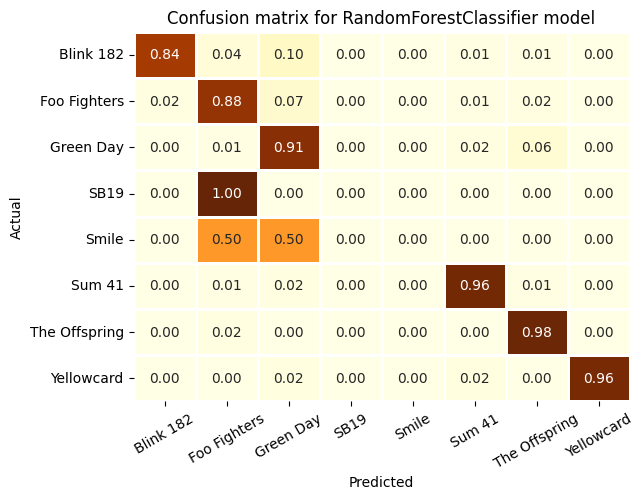

Building and fitting XGBClassifier...

 XGBClassifier Model
 Predicted labels
 2    122
5    116
1    108
0    105
7     89
6     65
dtype: int64 

Actual labels
 1    113
5    113
2    113
0    113
7     91
6     59
4      2
3      1
Name: artist_dummy, dtype: int64


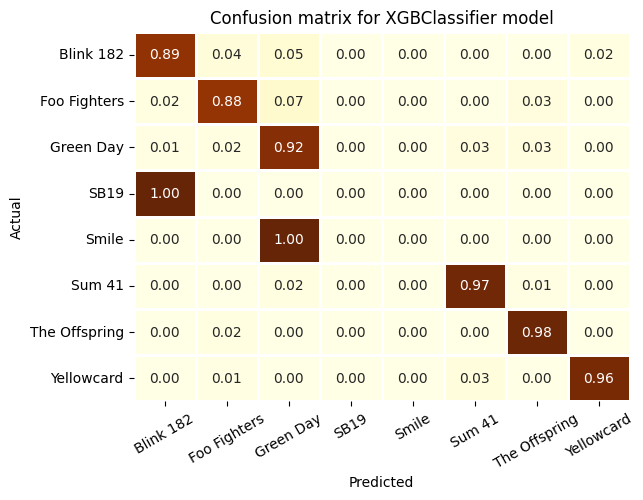

Building and fitting GradientBoostingClassifier...

 GradientBoostingClassifier Model
 Predicted labels
 2    120
5    114
1    113
0    102
7     89
6     66
4      1
dtype: int64 

Actual labels
 1    113
5    113
2    113
0    113
7     91
6     59
4      2
3      1
Name: artist_dummy, dtype: int64


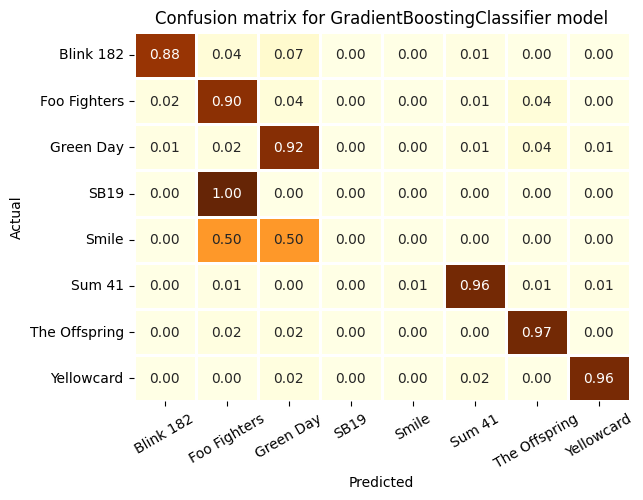

Building and fitting LogisticRegression...

 LogisticRegression Model
 Predicted labels
 2    126
5    119
7     99
1     96
0     94
6     71
dtype: int64 

Actual labels
 1    113
5    113
2    113
0    113
7     91
6     59
4      2
3      1
Name: artist_dummy, dtype: int64


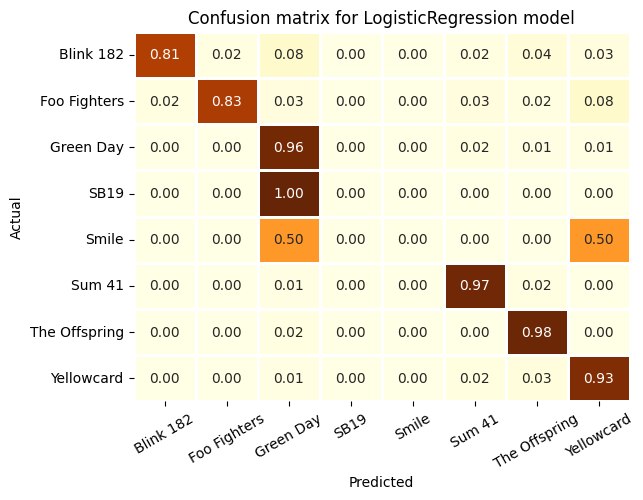

Building and fitting MultinomialNB...

 MultinomialNB Model
 Predicted labels
 5    126
2    116
0    106
1    104
7     98
6     55
dtype: int64 

Actual labels
 1    113
5    113
2    113
0    113
7     91
6     59
4      2
3      1
Name: artist_dummy, dtype: int64


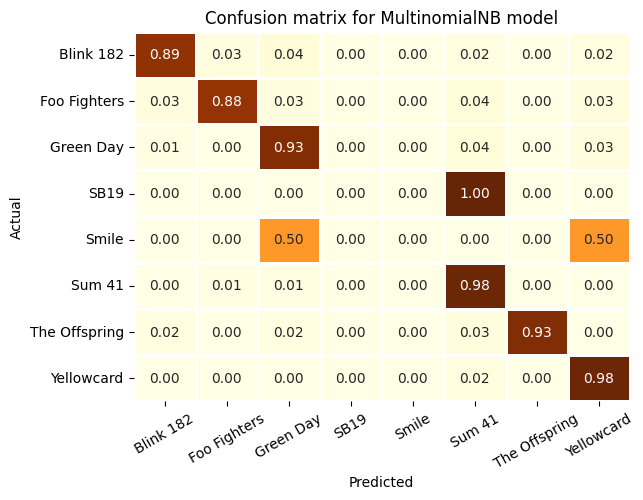

Building and fitting SVC...

 SVC Model
 Predicted labels
 2    126
5    115
1    104
0    104
7     93
6     63
dtype: int64 

Actual labels
 1    113
5    113
2    113
0    113
7     91
6     59
4      2
3      1
Name: artist_dummy, dtype: int64


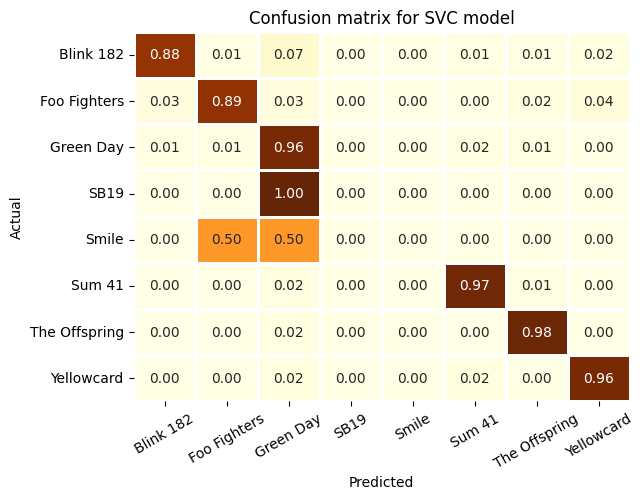

Building and fitting RidgeClassifier...

 RidgeClassifier Model
 Predicted labels
 2    122
5    116
0    104
1    101
7     98
6     64
dtype: int64 

Actual labels
 1    113
5    113
2    113
0    113
7     91
6     59
4      2
3      1
Name: artist_dummy, dtype: int64


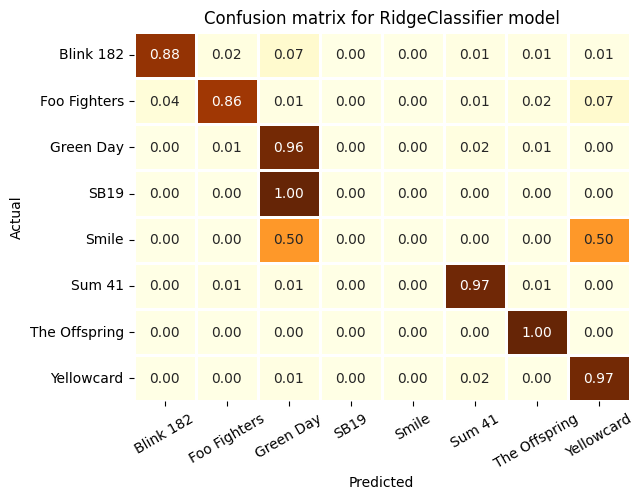

Building and fitting KNeighborsClassifier...

 KNeighborsClassifier Model
 Predicted labels
 5    132
2    108
0    104
7    100
1     98
6     62
3      1
dtype: int64 

Actual labels
 1    113
5    113
2    113
0    113
7     91
6     59
4      2
3      1
Name: artist_dummy, dtype: int64


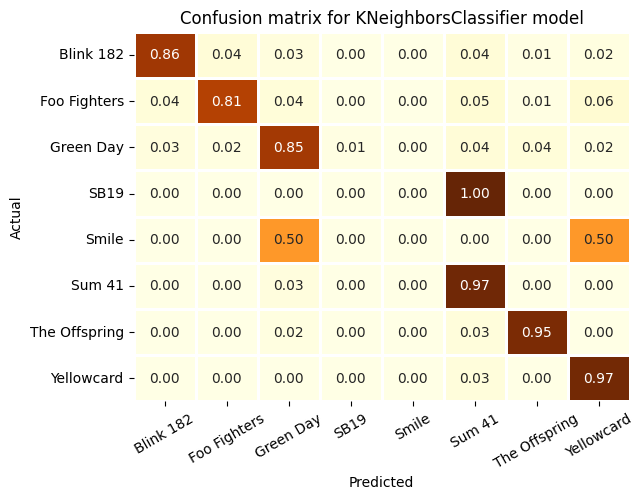

In [11]:
lyrics_models = []
for idx, classifier_object in enumerate(model_comparison["classifier model"]):
    if idx == 1:  # XGBoost needs dummy coded vars
        modelling_instance = LyricizerModelling(
            X_train=X_train,
            y_train=y_train.replace(
                {
                    "Blink 182": 0,
                    "Foo Fighters": 1,
                    "Green Day": 2,
                    "Smile": 3,
                    "Sum 41": 4,
                    "SB19": 5,
                    "The Offspring": 6,
                    "Yellowcard": 7,
                }
            ),
            X_test=X_test,
            y_test=y_test.replace(
                {
                    "Blink 182": 0,
                    "Foo Fighters": 1,
                    "Green Day": 2,
                    "Smile": 3,
                    "Sum 41": 4,
                    "SB19": 5,
                    "The Offspring": 6,
                    "Yellowcard": 7,
                }
            ),
            unmodelled_data=lyrics_data_unmodelled,
        )
    else:
        modelling_instance = LyricizerModelling(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            unmodelled_data=lyrics_data_unmodelled,
        )
    start = time.time()
    model, train_accuracy = modelling_instance.model_train(
        estimator_object=classifier_object,
        param_grid=model_comparison["param_grid"][idx],
        scoring="accuracy",
        cv=5,
        refit=True,
        n_jobs=n_jobs,
    )
    duration = time.time() - start
    accuracy, precision, recall, f1score = modelling_instance.model_evaluate(
        model,
        plot_confusion=True,
        xticklabels=list(lyrics_data["artist"].unique()),
        yticklabels=list(lyrics_data["artist"].unique()),
    )  # The original order of labels in the df is retained, so this should work even on weird splits
    model_comparison["gridsearch duration"].append(duration)
    model_comparison["training accuracy"].append(train_accuracy)
    model_comparison["test accuracy"].append(accuracy)
    model_comparison["precision"].append(precision)
    model_comparison["recall"].append(recall)
    model_comparison["f1-score"].append(f1score)
    try:
        model_comparison["best params"].append(model.best_params_)
    except:  # if no gridsearch
        model_comparison["best params"].append("no gridsearch")
    # for further evaluate, we could look at the precision-recall curve, for a multiclass model solution,
    # see https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    lyrics_models.append(modelling_instance)

In [ ]:
model_comparison = pd.DataFrame.from_dict(model_comparison).sort_values(
    by="test accuracy", ascending=False
)

##### Save model objects and model comparison df

In [13]:
model_comparison

,classifier name,classifier model,param_grid,best params,gridsearch duration,training accuracy,test accuracy,precision,recall,f1-score
5,Support Vector,"SVC(class_weight='balanced', random_state=42)","{'classifier__C': [1, 5], 'classifier__kernel'...","{'classifier__C': 5, 'classifier__degree': 3, ...",37.554682,1.000000,0.932231,0.932231,0.932231,0.932231
6,RidgeCV,RidgeClassifier(class_weight='balanced'),"{'classifier__alpha': [0.1, 0.2, 0.4, 0.6, 0.8...","{'classifier__alpha': 0.2, 'classifier__fit_in...",5.151518,1.000000,0.930579,0.930579,0.930579,0.930579
4,Naive Bayes,MultinomialNB(),"{'classifier__fit_prior': [True, False], 'clas...","{'classifier__alpha': 0.1, 'classifier__fit_pr...",3.941143,0.993929,0.927273,0.927273,0.927273,0.927273
1,XGBoost,"XGBClassifier(base_score=None, booster=None, c...","{'classifier__max_depth': [2, 10, 25, 50, 100,...","{'classifier__learning_rate': 0.5, 'classifier...",1358.075063,1.000000,0.925620,0.925620,0.925620,0.925620
2,GradientBoosting,GradientBoostingClassifier(random_state=42),"{'classifier__learning_rate': [0.1, 0.2, 0.4, ...",{'classifier__learning_rate': 0.1},317.859497,0.999448,0.922314,0.922314,0.922314,0.922314
0,Random Forest,RandomForestClassifier(class_weight='balanced'...,"{'classifier__max_depth': [2, 10, 25, 50, 100,...","{'classifier__criterion': 'gini', 'classifier_...",2119.384979,0.998896,0.912397,0.912397,0.912397,0.912397
3,Logistic Regression,"LogisticRegression(class_weight='balanced', n_...","{'classifier__fit_intercept': [True, False]}",{'classifier__fit_intercept': False},8.650533,0.994481,0.905785,0.905785,0.905785,0.905785
7,KNeighbors,KNeighborsClassifier(n_jobs=10),"{'classifier__n_neighbors': [5, 10, 20], 'clas...","{'classifier__n_neighbors': 5, 'classifier__we...",2.731197,1.000000,0.889256,0.889256,0.889256,0.889256


We see that all models fail to correctly classify bands with only a few songs (SB19 & Smile) during final evaluation. This is in spite of these bands being arguably the most different in terms of music and lyrics from the other bands. This is unsurprising due to at least two reasons: First, there is barely any observation for these two bands so the model is incredibly biased to classify all as not part of this very rare class, but second, there is also some degree of overfitting in all models as evidence by the difference in training and test accuracy. The rest of the bands, however, are decently well classified. What is not shown here, is that accuracy drops the more classes (artists) are added to the model, such that we drop from almost perfect accuracy, even for low n classes, when only having 2-3 target classes. Note that the level of overfitting is easily overlooked when only testing a model with relatively few classes because in these cases, the model is almost perfect at predicting test labels. A useful model, however, is more likely to have many more target classes, such that reducing the level of overfitting is a way more important factor in building a good model. The approach to reduce overfitting depends on the model one settles on.  

Although the support vector seems to perform best here, it should be noted that the Naive Bayes model is performing also very well and tends to be faster. But note that the gridsearch durations in the `model_comparison` df are only partially indicative of fitting durations here, since Naive Bayes was run with fewer hyperparameters to be tuned in gridsearch. A more direct fitting duration estimate can be derived when inspecting the model's own timing function, see stored model instance).

Note: Metrics are the same in multiclass problems when average "micro" is chosen.

This script has been run with standard string operations for the purpose of text formatting. Turns out for this dataset, the spacy text formatting doesn't improve but probably decreases the performance of the model.

In [12]:
model_comparison.to_csv("model_comparison_" + save_tag + ".csv")
with open("models__" + save_tag + ".pkl", "wb") as file:
    dill.dump(lyrics_models, file)

We finished by storing an entire class instances of each model. That way, we can explore all data and re-validate and -evaluate each model at a later point in time again. Note, in order to reproduce the model, we could also just save the crucial params.